# CANNs 介绍

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/routhleck/canns/HEAD?filepath=docs%2Fzh%2Fnotebooks%2F01_introduction.ipynb)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/routhleck/canns/blob/master/docs/zh/notebooks/01_introduction.ipynb)

欢迎使用 CANNs（连续吸引子神经网络）库！本笔记本介绍了这一强大神经网络建模框架的关键概念和功能。

## 什么是连续吸引子神经网络？

连续吸引子神经网络（CANNs）是一类特殊的神经网络模型，能够在连续状态空间中维持稳定的活动模式。与传统的处理离散输入输出的神经网络不同，CANNs 在以下方面表现优异：

- **空间表示**：通过群体活动编码连续的空间位置
- **工作记忆**：随时间维持和更新动态信息
- **路径积分**：基于运动信息计算位置变化
- **平滑跟踪**：跟踪连续变化的目标

## CANNs 库的关键特性

### 🏗️ 丰富的模型库
- **CANN1D/2D**：一维和二维连续吸引子网络
- **SFA 模型**：集成慢特征分析的模型
- **分层网络**：用于复杂信息处理的多层架构

### 🎮 面向任务的设计
- **路径积分**：空间导航和位置估计任务
- **目标跟踪**：动态目标的平滑连续跟踪
- **可扩展框架**：轻松添加自定义任务类型

### 📊 强大的分析工具
- **实时可视化**：能量景观、神经活动动画
- **统计分析**：放电率、调谐曲线、群体动态
- **数据处理**：z-score 标准化、时间序列分析

### ⚡ 高性能计算
- **JAX 加速**：基于 JAX 的高效数值计算
- **GPU 支持**：CUDA 和 TPU 硬件加速
- **并行处理**：针对大规模网络仿真进行优化

## 安装

CANNs 库可以使用 pip 安装，并根据您的硬件配置不同的版本：

In [ ]:
# 安装 CANNs（在终端中运行，不是在 notebook 中）
# 基础安装（CPU）
# !pip install canns

# GPU 支持（Linux）
# !pip install canns[cuda12]

# TPU 支持（Linux）
# !pip install canns[tpu]

## 基本使用示例

让我们从一个简单的示例开始，演示 CANNs 库的基本用法：

首先设置matplotlib的中文字体支持：

In [5]:
import brainstate
from canns.models.basic import CANN1D
from canns.task.tracking import SmoothTracking1D
from canns.analyzer.visualize import energy_landscape_1d_animation, energy_landscape_1d_static
import numpy as np

# 设置计算环境
brainstate.environ.set(dt=0.1)
print("BrainState environment configured with dt=0.1")

BrainState environment configured with dt=0.1


In [6]:
# 创建一个 1D CANN 网络
cann = CANN1D(num=512)
cann.init_state()

print(f"Created CANN1D with {cann.shape[0]} neurons")
print(f"Network shape: {cann.shape}")
print(f"Feature space range: [{cann.x.min():.2f}, {cann.x.max():.2f}]")

Created CANN1D with 512 neurons
Network shape: (512,)
Feature space range: [-3.14, 3.14]


## 了解网络结构

让我们探索 CANN 网络的基本属性：

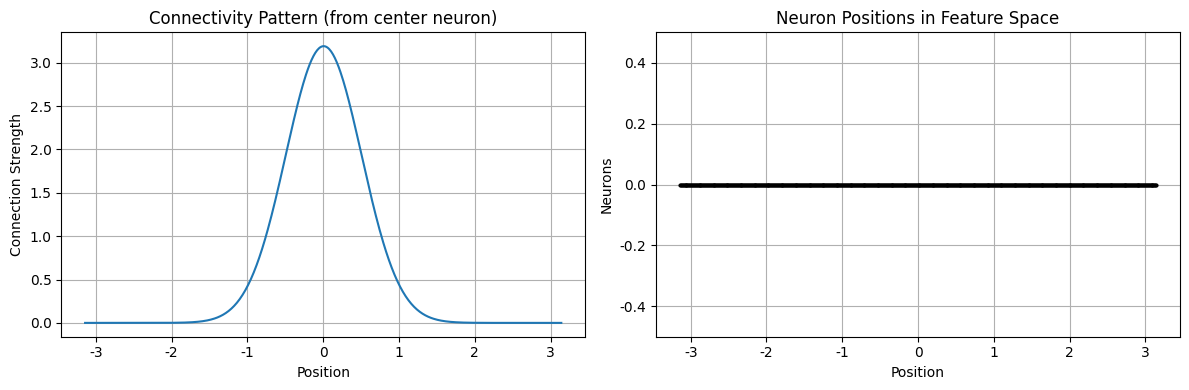

In [7]:
# 检查连接矩阵
import matplotlib.pyplot as plt

# 绘制连接矩阵（可视化的一小部分）
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# 绘制连接模式
center_idx = cann.shape[0] // 2
connectivity_slice = cann.conn_mat[center_idx, :]
ax1.plot(cann.x, connectivity_slice)
ax1.set_title('Connectivity Pattern (from center neuron)')
ax1.set_xlabel('Position')
ax1.set_ylabel('Connection Strength')
ax1.grid(True)

# 绘制网络位置
ax2.plot(cann.x, np.zeros_like(cann.x), 'ko', markersize=2)
ax2.set_title('Neuron Positions in Feature Space')
ax2.set_xlabel('Position')
ax2.set_ylabel('Neurons')
ax2.set_ylim(-0.5, 0.5)
ax2.grid(True)

plt.tight_layout()
plt.show()

## 创建简单跟踪任务

现在让我们创建一个平滑跟踪任务来观察网络的运行：

In [8]:
# 定义平滑跟踪任务
task = SmoothTracking1D(
    cann_instance=cann,
    Iext=(1., 0.75, 2., 1.75, 3.),  # 外部输入序列
    duration=(10., 10., 10., 10.),   # 每个阶段的持续时间
    time_step=brainstate.environ.get_dt(),
)

# 获取任务数据
task.get_data()

print(f"Task created with {len(task.data)} time steps")
print(f"Input sequence: {task.Iext}")
print(f"Phase durations: {task.duration}")

<SmoothTracking1D> Generating Task data: 400it [00:00, 2535.27it/s]

Task created with 400 time steps
Input sequence: (1.0, 0.75, 2.0, 1.75, 3.0)
Phase durations: (10.0, 10.0, 10.0, 10.0)


## 运行仿真

让我们运行网络仿真并观察其行为：

In [9]:
# 定义仿真步骤
def run_step(t, inputs):
    cann(inputs)
    return cann.u.value, cann.inp.value

# 运行仿真
print("Running simulation...")
us, inps = brainstate.compile.for_loop(
    run_step,
    task.run_steps,
    task.data,
    pbar=brainstate.compile.ProgressBar(10)
)

print(f"Simulation completed!")
print(f"Output shape: {us.shape}")
print(f"Input shape: {inps.shape}")

/Users/sichaohe/Documents/GitHub/canns/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running simulation...


Running for 400 iterations: 100%|██████████| 400/400 [00:00<00:00, 57878.41it/s]

Simulation completed!
Output shape: (400, 512)
Input shape: (400, 512)


## 可视化结果

现在让我们可视化网络活动，看看它是如何跟踪输入的：

Generating energy landscape animation...


<energy_landscape_1d_animation> Saving to introduction_demo.gif: 100%|██████████| 80/80 [00:04<00:00, 18.87it/s]


Animation successfully saved to: introduction_demo.gif


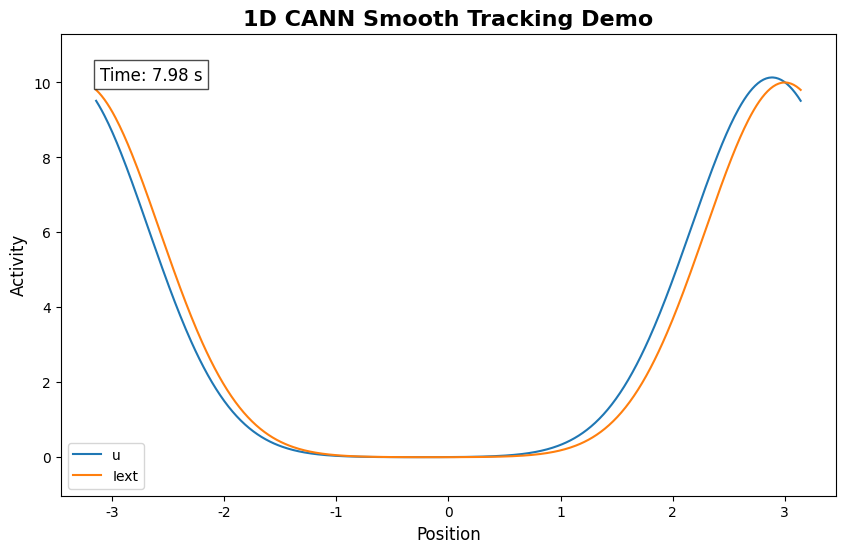

Animation saved as 'introduction_demo.gif'


In [10]:
# 创建能量景观动画
print("Generating energy landscape animation...")
energy_landscape_1d_animation(
    {'u': (cann.x, us), 'Iext': (cann.x, inps)},
    time_steps_per_second=50,
    fps=10,
    title='1D CANN Smooth Tracking Demo',
    xlabel='Position',
    ylabel='Activity',
    save_path='introduction_demo.gif',
    show=True,
)
print("Animation saved as 'introduction_demo.gif'")

## 关键观察结果

从这个基本示例中，您应该观察到：

1. **平滑跟踪**：网络活动（蓝线）平滑地跟随外部输入（红色虚线）
2. **连续表示**：活动形成一个在特征空间中连续移动的平滑波包
3. **稳定动态**：即使在输入变化时，网络也能维持稳定的活动模式
4. **群体编码**：多个神经元共同参与表示每个位置

## 下一步

本介绍涵盖了 CANNs 库的基础知识。在接下来的笔记本中，您将学习：

- **核心概念**：深入了解数学基础
- **1D 网络**：一维 CANNs 的详细探索
- **2D 网络**：二维空间表示
- **分层模型**：多层架构
- **自定义任务**：创建您自己的任务和实验
- **可视化**：高级绘图和分析技术
- **性能**：大规模仿真的优化和扩展

## 资源

- **GitHub 仓库**：https://github.com/routhleck/canns
- **文档**：[ReadTheDocs](https://canns.readthedocs.io/)
- **示例**：查看仓库中的 `examples/` 目录
- **问题和支持**：https://github.com/routhleck/canns/issues

准备探索更多内容？让我们继续学习[核心概念](03_core_concepts.ipynb)！